# **Step One: Reading the CSV File**

In [1]:
import pandas as pd

# File path
file_path = 'new_vehicles_dataset.csv'

# Read the file and display the first five rows
data = pd.read_csv(file_path)
print(data.head())

                                    Label (Grouping)  \
0  Census Tract 1011.10; Los Angeles County; Cali...   
1  Census Tract 1011.10; Los Angeles County; Cali...   
2  Census Tract 1011.10; Los Angeles County; Cali...   
3  Census Tract 1011.10; Los Angeles County; Cali...   
4  Census Tract 1011.10; Los Angeles County; Cali...   

          No vehicle available  
0                        4.80%  
1                         ±4.4  
2                        5.80%  
3                         ±6.5  
4                        3.80%  


# **Step Two: Display File Specifications**

In [2]:
# Display file specifications
print(f"The shape of the dataset is: {data.shape}")
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

The shape of the dataset is: (14988, 2)
Number of rows: 14988, Number of columns: 2


# **Step Three: Clean the Data**

In [3]:
# Print data structure to inspect content
print(data.head())
print(data.columns)

# Fix extra spaces or special characters in column names
data.columns = [col.strip() for col in data.columns]

# Filter data: Assume 'Label (Grouping)' contains keywords
filtered_data = data[
    data['Label (Grouping)'].str.contains("estimate", case=False, na=False) &  # Filter rows containing 'estimate'
    ~data['Label (Grouping)'].str.contains("Margin of Error", case=False, na=False) &  # Exclude rows containing 'Margin of Error'
    data.apply(lambda x: x.astype(str).str.contains('%').any(), axis=1)  # Keep rows containing '%'
]

# Display cleaned dataset
print("First five rows of the cleaned dataset:")
print(filtered_data.head())

                                    Label (Grouping)  \
0  Census Tract 1011.10; Los Angeles County; Cali...   
1  Census Tract 1011.10; Los Angeles County; Cali...   
2  Census Tract 1011.10; Los Angeles County; Cali...   
3  Census Tract 1011.10; Los Angeles County; Cali...   
4  Census Tract 1011.10; Los Angeles County; Cali...   

          No vehicle available  
0                        4.80%  
1                         ±4.4  
2                        5.80%  
3                         ±6.5  
4                        3.80%  
Index(['Label (Grouping)', '        No vehicle available'], dtype='object')
First five rows of the cleaned dataset:
                                    Label (Grouping) No vehicle available
0  Census Tract 1011.10; Los Angeles County; Cali...                4.80%
2  Census Tract 1011.10; Los Angeles County; Cali...                5.80%
4  Census Tract 1011.10; Los Angeles County; Cali...                3.80%
6  Census Tract 1011.22; Los Angeles County; Cali... 

In [4]:
# Define a function to filter rows that contain percentages in the correct format
def filter_percentages(value):
    if isinstance(value, str):
        # Check if the value is in a percentage format, e.g., "4.80%"
        return value.endswith('%') and value.replace('.', '', 1).replace('%', '').isdigit()
    return False

# Apply the filtering logic to the relevant column in the dataset
filtered_data = data[data['No vehicle available'].apply(filter_percentages)]

# Display the cleaned dataset
print("First five rows of the cleaned dataset:")
print(filtered_data.head())

First five rows of the cleaned dataset:
                                    Label (Grouping) No vehicle available
0  Census Tract 1011.10; Los Angeles County; Cali...                4.80%
2  Census Tract 1011.10; Los Angeles County; Cali...                5.80%
4  Census Tract 1011.10; Los Angeles County; Cali...                3.80%
6  Census Tract 1011.22; Los Angeles County; Cali...                0.00%
8  Census Tract 1011.22; Los Angeles County; Cali...                0.00%


In [5]:
# Create a new DataFrame, keeping only the required two columns
cleaned_data = filtered_data.copy()

# Rename columns
cleaned_data.columns = ['Census Tract', 'No vehicle available']

# Clean the "Census Tract" column to extract numeric parts
cleaned_data['Census Tract'] = cleaned_data['Census Tract'].str.extract(r'(\d+\.\d+)').astype(float)

# Convert percentages in the "No vehicle available" column to decimals
cleaned_data['No vehicle available'] = cleaned_data['No vehicle available'].str.replace('%', '', regex=False).astype(float) / 100

# Display the cleaned dataset
print("Cleaned dataset:")
print(cleaned_data.head())

Cleaned dataset:
   Census Tract  No vehicle available
0       1011.10                 0.048
2       1011.10                 0.058
4       1011.10                 0.038
6       1011.22                 0.000
8       1011.22                 0.000


# **Step Four: Normalization**

In [6]:
# Define a normalization function: Normalize non-zero values to the range [0, 1]
def normalize(value):
    if value == 0:
        return 0  # Keep as is if the value is 0
    return (value - cleaned_data['No vehicle available'].min()) / (
        cleaned_data['No vehicle available'].max() - cleaned_data['No vehicle available'].min()
    )

# Apply normalization to the "No vehicle available" column
cleaned_data['No vehicle available (normalized)'] = cleaned_data['No vehicle available'].apply(normalize)

# Display the normalized dataset
print("Normalized dataset:")
print(cleaned_data.head())


Normalized dataset:
   Census Tract  No vehicle available  No vehicle available (normalized)
0       1011.10                 0.048                              0.048
2       1011.10                 0.058                              0.058
4       1011.10                 0.038                              0.038
6       1011.22                 0.000                              0.000
8       1011.22                 0.000                              0.000


In [7]:
import numpy as np  # Ensure NumPy is imported

# Logarithmic transformation (add 1 to avoid log(0))
cleaned_data['No vehicle available (transformed)'] = cleaned_data['No vehicle available (normalized)'].apply(lambda x: np.log1p(x))

# Or square root transformation
cleaned_data['No vehicle available (transformed)'] = cleaned_data['No vehicle available (normalized)'].apply(lambda x: np.sqrt(x))

# Display the results
print(cleaned_data[['No vehicle available (normalized)', 'No vehicle available (transformed)']].head())

   No vehicle available (normalized)  No vehicle available (transformed)
0                              0.048                            0.219089
2                              0.058                            0.240832
4                              0.038                            0.194936
6                              0.000                            0.000000
8                              0.000                            0.000000


# Step 5: Display the Bar Chart

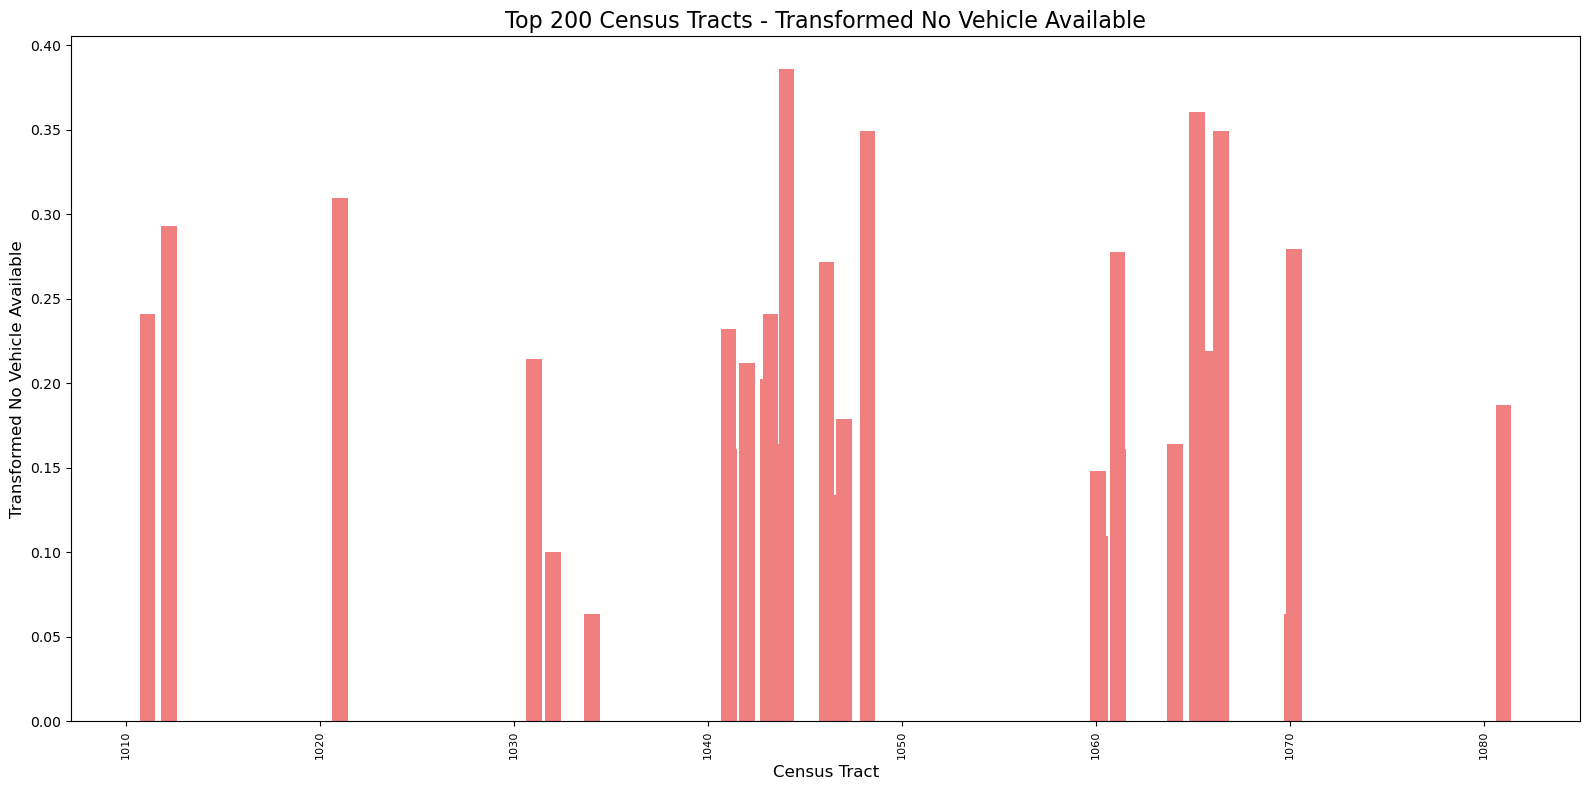

In [8]:
import matplotlib.pyplot as plt

# Select the top 200 rows of data
top_200_data = cleaned_data.head(200)

# Plot a bar chart
plt.figure(figsize=(16, 8))
plt.bar(top_200_data['Census Tract'], top_200_data['No vehicle available (transformed)'], color='lightcoral')

# Add title and axis labels
plt.title('Top 200 Census Tracts - Transformed No Vehicle Available', fontsize=16)
plt.xlabel('Census Tract', fontsize=12)
plt.ylabel('Transformed No Vehicle Available', fontsize=12)

# Rotate X-axis labels to avoid overlap
plt.xticks(rotation=90, fontsize=8)  # Adjust font size to fit more labels
plt.tight_layout()

# Display the chart
plt.show()

# Step 6: Match to the Map

Matched Census Tracts: 6093
Unmatched Census Tracts: 0
Data range in 'No vehicle available (transformed)':
count    5398.000000
mean        0.157804
std         0.130542
min         0.000000
25%         0.063246
50%         0.151658
75%         0.228035
max         1.000000
Name: No vehicle available (transformed), dtype: float64


<Figure size 1500x1500 with 0 Axes>

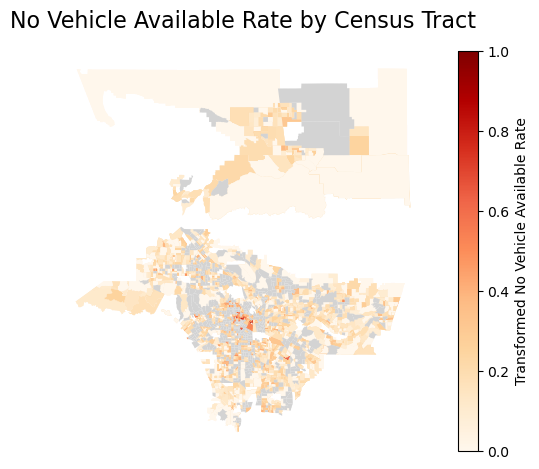

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load geographic data
shapefile_path = "2020_Census_Tracts.shp"  # Replace with the path to your .shp file
census_gdf = gpd.read_file(shapefile_path)

# Clean geographic data
census_gdf['Census_Tract'] = census_gdf['CT20'].astype(str).str.strip().str.zfill(6)

# Use previously cleaned data (assuming cleaned_data is the processed DataFrame)
normalized_data = cleaned_data.copy()

# Clean population data
normalized_data["Census_Tract"] = normalized_data["Census Tract"].astype(str).str.replace('.', '', regex=False).str.zfill(6)

# Merge geographic data with population data
merged_gdf = census_gdf.merge(
    normalized_data,
    left_on='Census_Tract',
    right_on='Census_Tract',
    how='left'
)

# Check merge results
print(f"Matched Census Tracts: {merged_gdf['Census_Tract'].notnull().sum()}")
print(f"Unmatched Census Tracts: {merged_gdf['Census_Tract'].isnull().sum()}")

# Check numerical column
print("Data range in 'No vehicle available (transformed)':")
print(merged_gdf['No vehicle available (transformed)'].describe())

# Plot the map
plt.figure(figsize=(15, 15))
merged_gdf.plot(
    column='No vehicle available (transformed)',  # Use the target column for visualization
    cmap='OrRd',  # Use a suitable color map
    legend=True,
    legend_kwds={'label': "Transformed No Vehicle Available Rate"},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}  # Color for missing data
)
plt.title("No Vehicle Available Rate by Census Tract", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()